In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
import keras_tuner as kt


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
tf.random.set_seed(2022)

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [5]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [6]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# Encode- Decoder + LSTM

Scale the input data

In [7]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [8]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
namespace= 'MS_EDLSTM_HPT'
modeltype = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [9]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [10]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model

In [11]:
def build_model_ED_LSTM(hp):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential()
  # Encoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
  model.add(layers.BatchNormalization())
  
  for i in range(hp.Int('n_layers',1,4,1)):
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
    model.add(layers.BatchNormalization())
  
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=False, stateful=False)) 
  model.add(layers.BatchNormalization())  
  
  # Repeat Vector
  model.add(layers.RepeatVector(n_outputs))
  
  # Decoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  for i in range(hp.Int('n_layers',1,4,1)):
      model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
      model.add(layers.BatchNormalization())

  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  # End
  model.add(layers.TimeDistributed(layers.Dense(1)))                     
              
  
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

In [12]:
tuner = kt.RandomSearch(
    build_model_ED_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 1,
    directory = "./hpt_ED_LSTM/",
    project_name="Load")
tuner.search_space_summary()


Search space summary
Default search space size: 2
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [13]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [14]:
num_epochs = 150
batch_size = 32

In [15]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Trial 10 Complete [00h 20m 28s]
val_loss: 7516321.5

Best val_loss So Far: 6665046.0
Total elapsed time: 03h 21m 04s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()

Results summary
Results in ./hpt_ED_LSTM/Load
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 2
Score: 6665046.0
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 4
Score: 6737732.5
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 2
Score: 6872659.5
Trial summary
Hyperparameters:
Neurons: 96
n_layers: 4
Score: 6953947.5
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 3
Score: 7516321.5
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 3
Score: 7747984.0
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 1
Score: 7905318.0
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 1
Score: 8107590.0
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 2
Score: 8456849.0
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 2
Score: 10090907.0


In [17]:
best_models = tuner.get_best_models()[0]
best_hps = tuner.get_best_hyperparameters(5)

In [18]:
# best_hps[0]

In [19]:
# %%skip $SKIP_RETRAIN_ED_LSTM
# model_ED_LSTM= build_model_ED_LSTM(best_hps[0])
# history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
#                                  callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [20]:
# %%skip $SKIP_RETRAIN_ED_LSTM
# histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
# histEDLSTM['epoch'] = history_ED_LSTM.epoch

In [21]:
# %%skip $SKIP_RETRAIN_ED_LSTM
# fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [22]:
#Calling back the best model:
# model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
# model_best_ED_LSTM.summary()

In [23]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(best_models.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]
y_test_filtered = y_test_filtered.squeeze(axis=1)

In [24]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

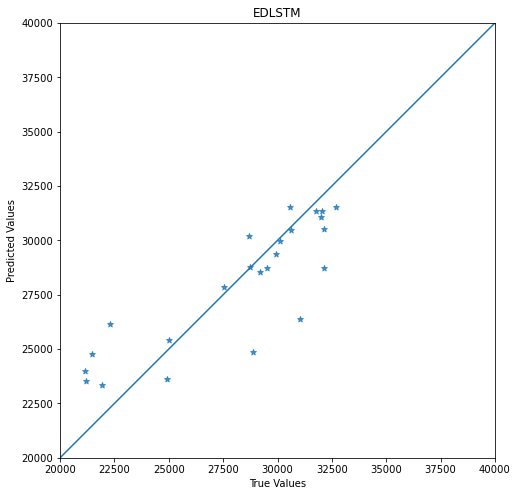

In [25]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

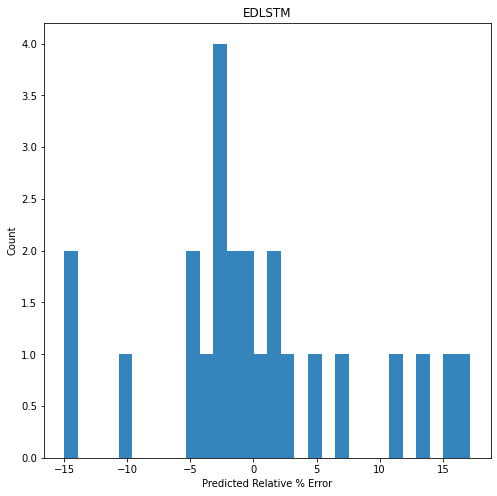

In [26]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [27]:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

5.931646130762602

In [28]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.72


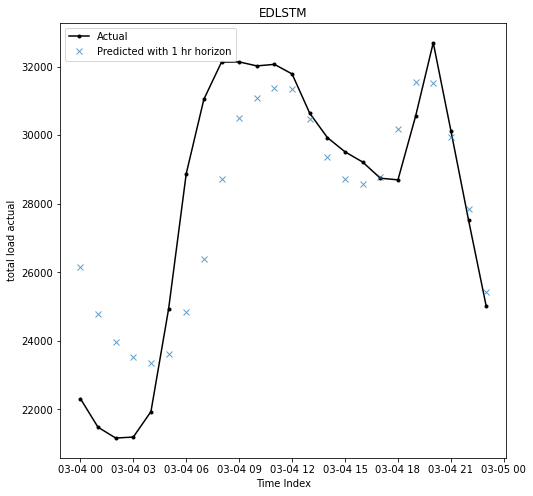

In [29]:
fig=plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/predictions_{namespace}.png")

In [30]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

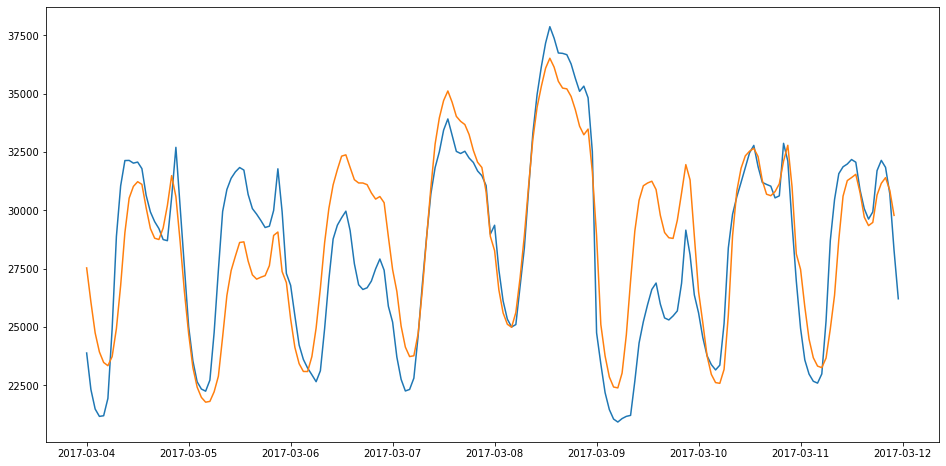

In [37]:
def make_twoweek_predictions(idx_test,data_y_test0,data_x_test):
    idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
    y_test_filtered2 = data_y_test0.loc[idx_prediction]
    df_pred =pd.DataFrame(index=y_test_filtered2.index)
        
    for i in range(len(data_x_test)):
        case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
        date_range = pd.date_range(start=idx_test[i],freq='h',periods=24)
        Y_test_predictions = pd.Series(best_models.predict(case_test).flatten(),index=date_range)
        df_pred[f'pred_{i}'] = Y_test_predictions
        
    df_pred['mean'] = df_pred.mean(axis=1)
    df_pred['Actual'] = y_test_filtered2
    return df_pred

def calculate_r2_scores(df_pred):
    r2_list=[]
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            r2_list.append(r2)
    return r2_list      
    
def plot_twoweek_predictions(df_pred,path,add_traces = False):
    mpl.rcParams['figure.figsize'] = [16, 8.0]
    fig,ax = plt.subplots(1)
    ax.plot(df_pred.index,df_pred['Actual'])
    ax.plot(df_pred.index,df_pred['mean'])
    if add_traces:
        for column in df_pred.columns:
            if column not in ['Actual','mean']:
                ax.plot(df_pred[column],'o')
    fig.savefig(path)
    return fig
    pass

df_pred = make_twoweek_predictions(idx_test=idx_test,data_y_test0=data_y_test0,data_x_test=data_x_test)
fig = plot_twoweek_predictions(df_pred,f'./{modeltype}/twoweek_predictions_{namespace}.png',add_traces=False)
r2 = calculate_r2_scores(df_pred)

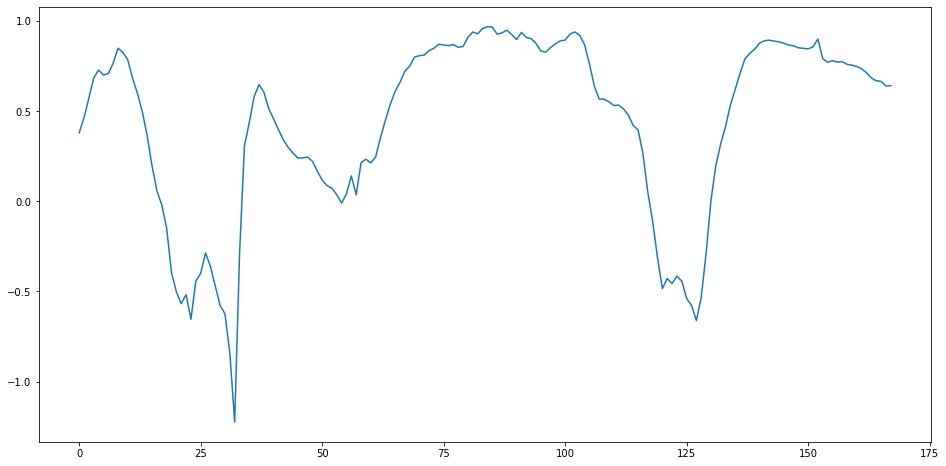

In [36]:
plt.figure()
plt.plot(r2)